## Part 3
Now go to the set of 29 images and repeat everything you did in Part 2 above for this larger dataset. 

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os
import itertools
import gtsam
import gtsam.utils.plot

In [2]:
# Part 1 Functions
def normalize_images(imgs):
    imgs_norm = []
    for img in imgs:
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        imgs_norm.append(img_norm)
    return imgs_norm

def grayscale_images(imgs):
    imgs_gray = []
    for img in imgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Apply CLAHE to grayscale images
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        imgs_gray.append(clahe.apply(gr))
    return imgs_gray

def find_features(sift_object, imgs_gray):
    kp = []
    des = []
    imgs_sift = []
    for img in imgs_gray:
        k, d = sift_object.detectAndCompute(img,None)
        img_sift = cv2.drawKeypoints(img, k, img, color=[255,255,0], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        imgs_sift.append(img_sift)
        kp.append(np.array(k))
        des.append(np.array(d))
    return kp, des, imgs_sift

def get_matches(kp1, des1, kp2, des2):
    # FLANN parameters https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html 
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    flann_match = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    good = []

    # ratio test as per Lowe's paper
    for m,n in flann_match:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.array([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.array([kp2[m.trainIdx].pt for m in good])

    return (src_pts, dst_pts)

def get_all_matches(kp, des):
    matches = []
    if len(kp) == 6:
        last_img_match = 0
    elif len(kp) == 28:
        last_img_match = 13
    else:
        print("Length of keypoints not expected")
        
    for i in range(len(kp)):
        ii = i+1 if i < len(kp)-1 else last_img_match
        matches.append(get_matches(kp[i], des[i], kp[ii], des[ii]))
        print("Image: ", i, ", ", ii, " Matches: ", len(matches[i][0]))

    return matches

def get_match_pts(kp_matches):
    pts_src = []
    pts_dst = []
    for kp_match in kp_matches:
        pts_src.append(np.float32([kp_match[0][i] for i in range(len(kp_match[0]))]))
        pts_dst.append(np.float32([kp_match[1][i] for i in range(len(kp_match[1]))]))
    return pts_src, pts_dst


def get_homography(kp_matches):
    h = []
    mask = []

    # if inliers were not already given to the homography function, get points and do RANSAC
    pts_src, pts_dst = get_match_pts(kp_matches)

    # this is only for the last run
    for i in range(len(pts_src)):
        h_img, mask_img = cv2.findHomography(pts_dst[i],pts_src[i],cv2.RANSAC,3.0)
        h.append(h_img)
        mask.append(mask_img)
    return h, mask, (pts_src, pts_dst)

def adjust_image_frame(H, src_shape, dst_shape):
    # Get corners of the source image
    (h, w) = src_shape
    img_corners = np.float32([[0, 0],
                            [w - 1, 0],
                            [w - 1, h - 1],
                            [0, h - 1]])
    
    # Convert to Array in Homogeneous Coordinates
    corners_base = np.array([img_corners[:, 0],
                            img_corners[:,1],
                            np.ones(4)])

    # Calculate distorted corner pixel coordinates by multiplying by Homography matrix
    corners_distorted = np.dot(H, corners_base)
    [x, y, c] = corners_distorted
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the distorted image frame
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    # Fit Right Side of Image
    w_stitched = max(max_x, dst_shape[1])
    h_stitched = max(max_y, dst_shape[0])

    # Add offset if distorted stitching goes out of current image frame
    offset = [0, 0]
    if min_x < 0:
        offset[0] = abs(min_x)
        w_stitched += offset[0]
    if min_y < 0:
        offset[1] = abs(min_y)
        h_stitched += offset[1]

    # Add offset to stitched corner coordinates
    corners_stitched = np.float32(np.array([x + offset[0], y + offset[1]]).transpose())

    # Recompute homography s.t. the source image is in frame
    H = cv2.getPerspectiveTransform(img_corners, corners_stitched)
    
    return [h_stitched, w_stitched], offset, H


def alpha_blending(img1, img2):
    # Blend images together
    black = np.zeros(img1.shape, dtype=np.uint8)
    mask_dst = cv2.inRange(img1, np.array([0,0,0]), np.array([0,0,0]))
    mask_src = cv2.inRange(img2, np.array([0,0,0]), np.array([0,0,0]))

    # Get the non-overlapping components of both images
    dst_fringe = cv2.bitwise_or(img1, img2, mask=mask_dst)
    src_fringe = cv2.bitwise_or(img1, img2, mask=mask_src)

    # Get the overlapping region and set it to white to use as a mask
    overlap_region = cv2.bitwise_and(
        cv2.bitwise_or(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_dst)),
        cv2.bitwise_or(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_src)))
    overlap_region[overlap_region>0.0] = 255

    # Blend only the overlapping regions of the image
    img_overlap_blend = cv2.addWeighted(
        cv2.bitwise_or(img2, black, mask=overlap_region), 0.5,
        cv2.bitwise_or(img1, black, mask=overlap_region), 0.5, 0.0)

    return dst_fringe + src_fringe + img_overlap_blend


def stitch_images(img_dst, img_src, H):
    # Finding size of new frame of stitched images and updating the homography matrix 
    stitched_dims, offset, H = adjust_image_frame(H, img_src.shape[:2], img_dst.shape[:2])
    # Finally placing the images upon one another.
    src_warped = cv2.warpPerspective(img_src, H, (stitched_dims[1], stitched_dims[0]))

    # Expand destimation image frame to fit source image
    dst_transformed = np.zeros((stitched_dims[0], stitched_dims[1], 3), dtype=np.uint8)
    dst_transformed[offset[1]:offset[1]+img_dst.shape[0], offset[0]:offset[0]+img_dst.shape[1]] = img_dst

    img_stitched = alpha_blending(dst_transformed, src_warped)

    return img_stitched, offset

def stitch_all_images(imgs, h):
    img_offset = [0,0]
    img_mosaic = imgs[0]
    h[-1] = np.identity(3) 

    if len(imgs) == 6:
        last_img_match = 0
    elif len(imgs) == 28:
        last_img_match = 13
    else:
        print("Length of keypoints not expected")

    for i in range(len(h)-1):
        h[i][0][2] += img_offset[0]
        h[i][1][2] += img_offset[1]
        h[i] = np.dot(h[i],h[i-1]) # h[-1] defined as identity for first homography
        
        ii = i+1 if i < len(imgs)-1 else last_img_match
        img_mosaic, img_offset = stitch_images(img_mosaic,imgs[ii],h[i])
    return img_mosaic

In [3]:
# Part 2 Functions
def noise_model(mask):
    numMatches = np.count_nonzero(mask)
    
    if numMatches > 200:
        err = [0.2, 0.2, 0.1] # Minimum Error
    elif numMatches > 100 and numMatches <= 200:
        err = [0.5, 0.5, 0.2]
    elif numMatches > 50 and numMatches <= 100:
        err = [0.8, 0.8, 0.4]
    else:
        err = [1.0, 1.0, 0.5] # Maximum Error
    
    return gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(err[0], err[1], err[2]))

affine_mask = []
def get_factor_pose(index, pts_src, pts_dst):
    global affine_mask

    # Computes an optimal limited affine transformation with 4dof between 2 2D point sets
    affine_mat, affine_mask = cv2.estimateAffinePartial2D(pts_dst[index],pts_src[index])

    # Normalize and put in homogeneous coordinates
    affine_mat[:2, :2] /= np.linalg.norm(affine_mat[:2, 0])
    mat = np.vstack((affine_mat, [0, 0, 1]))

    return gtsam.Pose2(mat[0, -1], mat[1, -1],
                np.arctan2(mat[1, 0], mat[0, 0]))

def get_homography_pose(h):
   # Find Relative Transform from Homography
   h_inv = np.linalg.inv(h)
   pos = [h_inv[0,2], h_inv[1,2]]
   rot = np.arctan2(h_inv[1,0], h_inv[0,0])
   return gtsam.Pose2(pos[0], pos[1], rot)

def get_initial_estimate(h):
    initial_estimate = gtsam.Values()
    initial_estimate.insert(0, gtsam.Pose2())
    
    for i in range(len(h)-1):
        initial_estimate.insert(i+1, get_homography_pose(h[i]))
        
    return initial_estimate

def plot_graph(values, graph, marginals):

    # Plot Pose from gtsam
    for vertex_index in range(values.size()):
        gtsam.utils.plot.plot_pose2(0, values.atPose2(vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    # Plot lines between poses
    for img_match in range(graph.size())[1:]:
        k1, k2 = graph.at(img_match).keys()
        line_start = values.atPose2(k1)
        line_end = values.atPose2(k2)
        plt.plot([line_start.x(), line_end.x()], [line_start.y(), line_end.y()], color='orange')
    plt.title('GTSAM Factor Graph')
    plt.axis('off')
    plt.show()

def get_optimized_homography(initial_pose, imgs):
    poses = gtsam.utilities.allPose2s(initial_pose)
    h_list = []
    for i in range(len(imgs)):
        pose = poses.atPose2(i)
        h = pose.matrix()
        # From image origin (center of image)
        translation_matrix = np.eye(3)
        translation_matrix[:2, 2] -= np.array([img_w/2, img_h/2]).T
        h_list.append(h.dot(translation_matrix))
    return h_list

def get_optimized_mosaic_dimensions(h_list):
    # Get image corners in homogeneous coordinates
    img_corners = np.float32([[0, 0, 1],
                            [img_w - 1, 0, 1],
                            [img_w - 1, img_h - 1, 1],
                            [0, img_h - 1, 1]]).T

    # Get all corners of every warped image and find the bottom left and top right corners
    all_corners = []
    for h in h_list:
        # Distort and Normalize image corners
        [x, y, c] = np.dot(h, img_corners)
        x = np.divide(x, c)
        y = np.divide(y, c)
        for i in range(len(x)):
            all_corners.append(np.array([x[i], y[i]]))

    bottom_left = (np.floor(np.amin(all_corners, axis=0))).astype(np.int32)
    top_right = (np.ceil(np.amax(all_corners, axis=0))).astype(np.int32)

    # Get the total stitched image dimensions
    stitch_image_size = top_right - bottom_left

    # Define offset for image stitching
    offset_matrix = np.eye(3, dtype=np.float64)
    if bottom_left[0] < 0: offset_matrix[0, 2] -= bottom_left[0]
    if bottom_left[1] < 0: offset_matrix[1, 2] -= bottom_left[1]

    return stitch_image_size, offset_matrix

def stitch_all_images_optimized(h_list, imgs):
    # Find the resulting total dimensions of the fully stitched mosaic image
    img_size, offset_matrix = get_optimized_mosaic_dimensions(h_list)

    # Set image dimensions
    stitch_image = np.zeros((img_size[1], img_size[0], 3), np.uint8)

    # Stitch all images
    for homography_matrix, image in zip(h_list, imgs):
        warp_image = cv2.warpPerspective(
            image, offset_matrix.dot(homography_matrix), img_size)
        stitch_image = alpha_blending(stitch_image,warp_image)
    return stitch_image

Image:  0 ,  1  Matches:  410
Image:  1 ,  2  Matches:  247
Image:  2 ,  3  Matches:  215
Image:  3 ,  4  Matches:  305
Image:  4 ,  5  Matches:  102
Image:  5 ,  6  Matches:  192
Image:  6 ,  7  Matches:  56
Image:  7 ,  8  Matches:  512
Image:  8 ,  9  Matches:  585
Image:  9 ,  10  Matches:  591
Image:  10 ,  11  Matches:  571
Image:  11 ,  12  Matches:  393
Image:  12 ,  13  Matches:  51
Image:  13 ,  14  Matches:  558
Image:  14 ,  15  Matches:  481
Image:  15 ,  16  Matches:  763
Image:  16 ,  17  Matches:  575
Image:  17 ,  18  Matches:  746
Image:  18 ,  19  Matches:  825
Image:  19 ,  20  Matches:  263
Image:  20 ,  21  Matches:  532
Image:  21 ,  22  Matches:  711
Image:  22 ,  23  Matches:  381
Image:  23 ,  24  Matches:  577
Image:  24 ,  25  Matches:  569
Image:  25 ,  26  Matches:  463
Image:  26 ,  27  Matches:  375
Image:  27 ,  13  Matches:  198


(-0.5, 1362.5, 1296.5, -0.5)

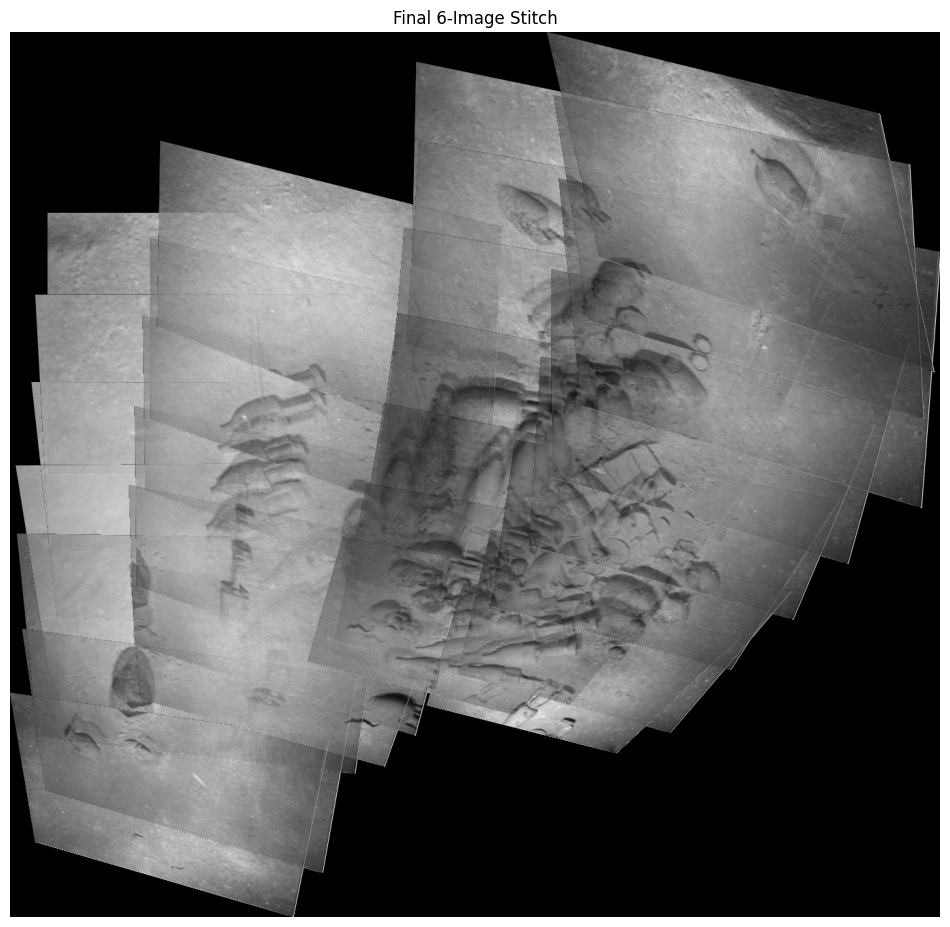

In [4]:
# Save images in a list
imgs = []
dir_name = '29images/'
list_of_files = sorted( filter( os.path.isfile, glob.glob(dir_name + '*')))
for file_path in list_of_files: imgs.append(cv2.imread(file_path))

imgs_norm = normalize_images(imgs)
imgs_gray = grayscale_images(imgs_norm)
img_h, img_w = imgs_gray[0].shape

# Create SIFT Object and save keypoints, descriptors, and sift-labeled images
sift = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)
kp, des, imgs_sift = find_features(sift, imgs_gray)

matches = get_all_matches(kp, des)

h, mask, pts_corr = get_homography(matches)

img_mosaic = stitch_all_images(imgs_norm, h)

plt.figure(figsize = (12,12))
plt.imshow(img_mosaic)
plt.title("Final 6-Image Stitch")
plt.axis('off')

In [5]:
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))

# Create a factor graph container and add factors to it
graph = gtsam.NonlinearFactorGraph()

# Add a prior on the zeroth pose, setting it to the origin (middle of a normalized image)
# A prior factor consists of a mean and a noise (covariance matrix)
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(img_w/2, img_h/2, 0), prior_noise))



initial = get_initial_estimate(h)

# Loop through all combinations of images
for src_index, dst_index in itertools.combinations(range(len(imgs_norm)), 2):

    # Add Factor Poses for adjacent images
    if src_index + 1 == dst_index:
        graph.add(gtsam.BetweenFactorPose2(
            src_index, dst_index,
            get_factor_pose(src_index, pts_corr[0], pts_corr[1]), 
            noise_model(mask[src_index])))
        
    # Find Loop Closures
    else: 
        kp_match_overlap = [get_matches(kp[src_index], des[src_index], kp[dst_index], des[dst_index])]
        
        # Only accept loop closure if more than 20 matches
        if len(kp_match_overlap[0][0]) < 20: continue 

        pts_src, pts_dst = get_match_pts(kp_match_overlap)

        graph.add(gtsam.BetweenFactorPose2(
            src_index, dst_index,
            get_factor_pose(0, pts_src, pts_dst), 
            noise_model(affine_mask)))

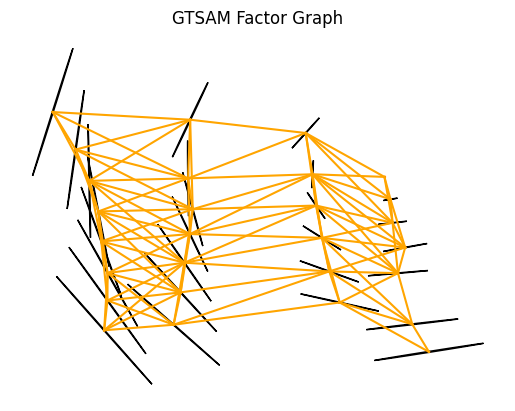

In [6]:
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

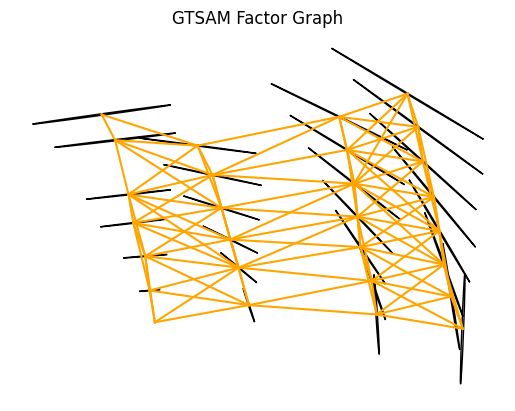

In [7]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

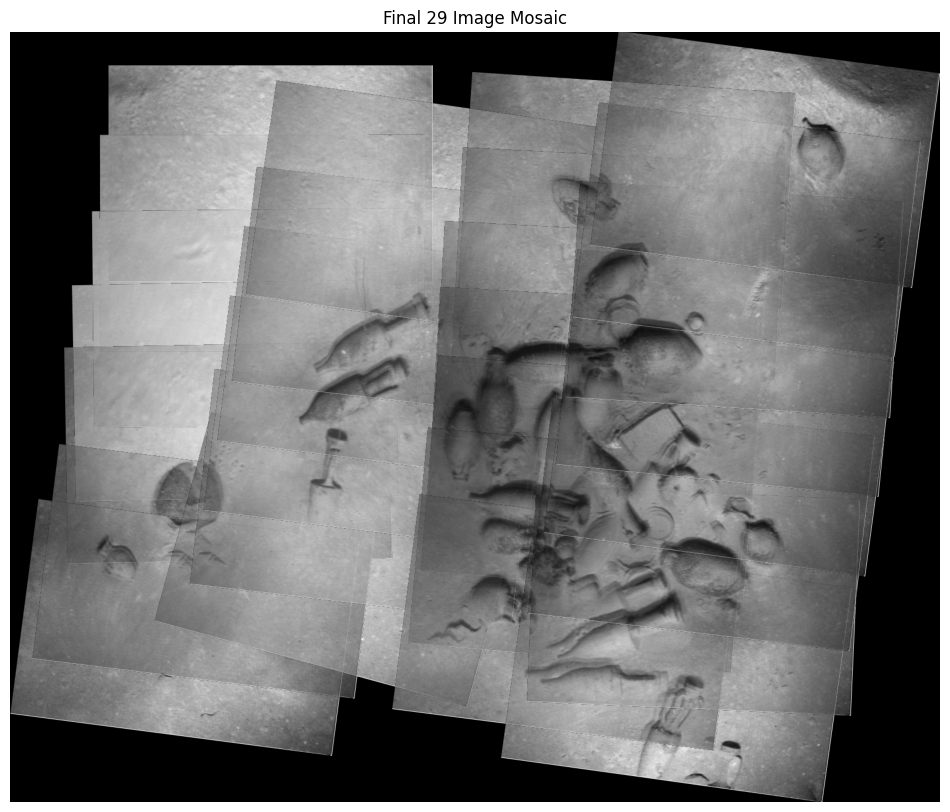

In [9]:
# Get the optimized homography matrices from GTSAM Output
h_optimized_list = get_optimized_homography(initial, imgs_norm)

# Stitch all the images together
stitch_image = stitch_all_images_optimized(h_optimized_list, imgs_norm)

plt.figure(figsize = (12,12))
plt.imshow(stitch_image)
plt.title('Final 29 Image Mosaic')
plt.axis('off')
plt.show()